In [1]:
import torch
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import tqdm 
import copy
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
# These are all of the files you are given
df_tr = pd.read_csv("kaggle_data/train.csv")

In [3]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [4]:
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15

df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [5]:
from datetime import datetime
def parse_time(x):

    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [6]:
ct = pd.get_dummies(df_tr['CALL_TYPE'])
ct.columns = ['ct_A','ct_B','ct_C']

In [7]:
df_tr.loc[df_tr['CALL_TYPE'] == 'A', 'ORIGIN_STAND'] = 0
df_tr.loc[df_tr['CALL_TYPE'] == 'C', 'ORIGIN_STAND'] = -1
df_tr['ORIGIN_STAND'] = df_tr['ORIGIN_STAND'].fillna(-2)

In [8]:
stan = pd.get_dummies(df_tr['ORIGIN_STAND'])

In [9]:
cols = ['YR','MON','DAY','HR','WK','ct_A','ct_B','ct_C']+list(stan.columns)

In [10]:
df_feat = pd.concat([df_tr,ct,stan],axis=1)
X = df_feat[cols].to_numpy().astype(float)
y = df_feat['LEN'].to_numpy().astype(float)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [14]:
device = torch.device('cpu')

In [15]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

In [16]:
input_size = 50

In [17]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(RNN, self).__init__()
        #self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_seq, hidden_state):
        #embedding = self.embedding(input_seq)
        #output, hidden_state = self.rnn(embedding, hidden_state)
        output, hidden_state = self.rnn(input_seq, hidden_state)
        output = self.decoder(output)
        return output, (hidden_state[0], hidden_state[1])

In [29]:
model = RNN(input_size=74, output_size=1, hidden_size=256).to(device)

In [19]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [20]:
from torch.optim.lr_scheduler import StepLR 
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [21]:
save = {'w':None,'history':[],'mse':np.inf}

In [22]:
n_epochs = 50   # number of epochs to run
batch_size = 256  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [23]:
best_mse = save['mse']  # init to infinity
best_weights = save['w']
history_train = []
history_test = []

In [24]:
df_sorted = df_feat.sort_values(by=['TAXI_ID', 'TIMESTAMP'])

In [25]:
drives_by_taxi = list(df_sorted.groupby('TAXI_ID')[cols])

In [26]:
input_data = [torch.tensor(drive[1].to_numpy(), dtype=torch.float32) for drive in drives_by_taxi]

In [27]:
max_length = max(tensor.size(0) for tensor in input_data)

padded_tensors = []
for tensor in input_data:
    pad_length = max_length - tensor.size(0)
    padded_tensor = torch.nn.functional.pad(tensor, (0, 0, 0, pad_length))
    padded_tensors.append(padded_tensor)

tensor_3d = torch.stack(padded_tensors)

In [34]:
for i_epoch in range(1):
    n=0
    running_loss = 0
    
    for i in tqdm.tqdm(range(5, len(tensor_3d) - 1, 3)):
        hidden_state = None
        input_seq = tensor_3d[i-5: i]
        #target_seq = tensor_3d[i-5+1:i+1]
        
        output, _ = model(input_seq, hidden_state)
        
        #loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq))
        #running_loss += loss.item()
        #n += 1
        
        optimizer.zero_grad()
        #loss.backward()
        optimizer.step()
        
    #print("Epoch: {0} \t Loss {1:.8f}".format(i_epoch, running_loss/n))

100%|██████████| 148/148 [04:12<00:00,  1.71s/it]


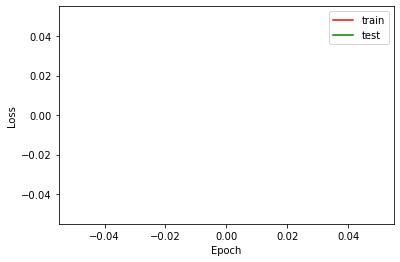

In [69]:
# Plotting both the curves simultaneously
plt.plot(np.sqrt(history_train), color='r', label='train')
plt.plot(np.sqrt(history_test), color='g', label='test')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epoch")
plt.ylabel("Loss")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

In [39]:
import math
def fillos(x):
    if x['CALL_TYPE'] == 'B':
        if type(x['ORIGIN_STAND']) == None:
            return -1
        else:
            return x['ORIGIN_STAND']
    if x['CALL_TYPE'] == 'A':
        return 0
    else:
        return -1

In [40]:
test = pd.read_csv('kaggle_data/test_public.csv')
tid =  test[['TRIP_ID']]
test[["YR", "MON", "DAY", "HR", "WK"]] = test[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
ct_test = pd.get_dummies(test['CALL_TYPE'])
ct_test.columns = ['ct_A','ct_B','ct_C']
enc = OneHotEncoder()
enc.fit(np.array(df_tr[['OS_F']]))
test['OS_F'] = test.apply(fillos,axis=1)
stan_test = pd.DataFrame(enc.transform(test[['OS_F']]).toarray())
stan_test.columns = stan_test.columns -1
stan_test = stan_test.drop([64],axis=1)
test = pd.concat([test,ct_test,stan_test],axis=1)
test = test[['YR','MON','DAY','HR','WK','ct_A','ct_B','ct_C']+list(stan_test.columns)].to_numpy().astype(float)
test = torch.tensor(test, dtype=torch.float32).to(device)

KeyError: "None of [Index(['OS_F'], dtype='object')] are in the [columns]"

In [36]:
model(test)

NameError: name 'test' is not defined

In [91]:
test.shape

torch.Size([320, 73])

In [ ]:
model.load_state_dict(best_weights)

In [17]:
model.load_state_dict(torch.load('weight.pt'))

<All keys matched successfully>

In [93]:
pred = model(test).cpu().detach().numpy().transpose()[0]
tid['TRAVEL_TIME'] = pred
tid

,TRIP_ID,TRAVEL_TIME
0,T1,726.462708
1,T2,711.665710
2,T3,755.038391
3,T4,566.988892
4,T5,723.124390
...,...,...
315,T323,603.548340
316,T324,525.464294
317,T325,611.454651
318,T326,621.247681


In [94]:
tid.to_csv('sampSubmission3.csv',index=False)

In [71]:
torch.save(best_weights, 'weight.pt')

In [19]:
Xt = torch.tensor(X,dtype=torch.float32).to(device)

In [21]:
torch.cuda.empty_cache()

In [22]:
dist = pd.DataFrame((model(Xt) - yt).cpu().detach().numpy().transpose()[0])

OutOfMemoryError: CUDA out of memory. Tried to allocate 10901.66 GiB (GPU 0; 10.76 GiB total capacity; 3.84 GiB already allocated; 5.86 GiB free; 4.16 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [23]:
pred = model(Xt)

In [26]:
pred = pred.cpu().detach().numpy()

In [ ]:
pred - y

In [258]:
tensor_3d

tensor([[[2.0130e+03, 7.0000e+00, 1.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.0130e+03, 7.0000e+00, 1.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.0130e+03, 7.0000e+00, 1.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 1.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[2.0130e+03, 7.0000e+00, 6.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.0130e+03, 7.0000e+00, 6.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.0130e+03, 7.0000e+00, 6.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.000

In [249]:
input_data

[tensor([[2.0130e+03, 7.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.0130e+03, 7.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.0130e+03, 7.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         ...,
         [2.0140e+03, 6.0000e+00, 3.0000e+01,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.0140e+03, 6.0000e+00, 3.0000e+01,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.0140e+03, 6.0000e+00, 3.0000e+01,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 tensor([[2013.,    7.,    6.,  ...,    0.,    0.,    0.],
         [2013.,    7.,    6.,  ...,    0.,    0.,    0.],
         [2013.,    7.,    6.,  ...,    0.,    0.,    0.],
         ...,
         [2014.,    6.,   30.,  ...,    0.,    0.,    0.],
         [2014.,    6.,   30.,  ...,    0.,    0.,    0.],
         [2014.,    6.,   30.,  ...,    0.,    0.,    0.]]),
 tensor([[2013.,    

In [237]:
input_data

[tensor([[2.0130e+03, 7.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.0130e+03, 7.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.0130e+03, 7.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         ...,
         [2.0140e+03, 6.0000e+00, 3.0000e+01,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.0140e+03, 6.0000e+00, 3.0000e+01,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.0140e+03, 6.0000e+00, 3.0000e+01,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 tensor([[2013.,    7.,    6.,  ...,    0.,    0.,    0.],
         [2013.,    7.,    6.,  ...,    0.,    0.,    0.],
         [2013.,    7.,    6.,  ...,    0.,    0.,    0.],
         ...,
         [2014.,    6.,   30.,  ...,    0.,    0.,    0.],
         [2014.,    6.,   30.,  ...,    0.,    0.,    0.],
         [2014.,    6.,   30.,  ...,    0.,    0.,    0.]]),
 tensor([[2013.,    